###### For my Final Project I set a goal to try to use data from soccer matches to predict the results of those matches.  I got a trial API key from SportRadar and pulled down their data for MLS matches into a MySQL Database.  Their data consisted of some basic stats such as scores, shots, fouls, corner kicks but also some advanced stats such as possession, dangerous attacks, ball safe, etc...  Using the data pulled from the database, I made some calculations that weren't available from the API but important in Soccer matches such as Goal Differential and teams Strength of Schedule.  Using this data, I ran multiple models using various features to discover the best model to predict which team will win/lose.

SIDE NOTE: would love to get any critiques, hints, tips, oberservations on any level not just on ML (but obviously ML as the priority).  Beginner Python learner (though I took the Full Stack Course) so any suggestions there are welcome.  Thanks.

Will need to import these libs plus setting some global variables

In [3]:
import sys
import os
import numpy as np
import renders as rs
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Might need to change the path of the included libraries.
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/match_stats.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_model.py')
sys.path.append('/anaconda/envs/stats/lib/python3.5/site-packages')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/model_libs.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_data.py')
sys.path.append('/Users/senzari/Machine_Learning/stats')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats')
# print(sys.path)
os.chdir('/Users/senzari/Machine_Learning/stats/src')
#print(os.getcwd())

from stats import form_data, match_stats, model_libs, form_model, predict_matches

# Variables
round_number = 26
target_col = 'points'
ignore_cols = ['match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'scheduled']
models = ['svc', 'gmm', 'knn', 'gnb']

""" this varialbe 'testing' should be false if using CSV's and not pulling from the database. """
testing = False

INITIALIZED...


Pulling in the data either from the Database or the CSV (CSV for testers).  Data has some added features in between the database and 'raw_data'.  Essentially trying 3 different versions of the data in this set.  One version contains all the features.  Another version has the standard features plus the calculated features of the home/away stats for a matchup.  The last version has the standard features plus the 'extended features' which not only includes the stats of the two teams in the match up but also the current teams previous opponents and the current teams opponents of the team opponents in that matchup.

In [22]:
data_csv = 'round' + str(round_number) + '.csv'

if testing:
    raw_data = form_data.run_data()
    raw_data.to_csv(data_csv)
    print("Raw Data Saved to CSV")
else:
    #Reading in a CSV adds the first index column
    raw_data = pd.read_csv(data_csv)
    raw_data = raw_data.drop(raw_data.columns[[0]], axis=1)

pd.set_option("display.max_columns", 85)
print('Data Loaded...')

Data Loaded...


In [23]:
print(raw_data.shape)

(480, 82)


Functions that trains basic models (and saves them if need be).  'load_models' will  load exisiting models to save time in testing.

In [24]:
# Removes Columns to Ignore and Splits the Target Column
def split_target(data):
    td = model_libs._clone_and_drop(data, ignore_cols)
    (y, X) = model_libs._extract_target(td, target_col)
    return X, y

"""No Cross-Validation and No Tuning"""
def train_models(round_num, X, y):
    
    if os.path.isdir("/models/" + str(round_num)):
        print('Making New Directory for the Round')
        os.chdir('/Users/senzari/Machine_Learning/stats/src/models')
        os.makedirs(str(round_num))
        os.chdir('/Users/senzari/Machine_Learning/stats/src')
    
    for i in models:
        
        model_round = 'models/' + str(round_num) + '/' + str(i) + '_round_' + str(round_num) + '.pk1'
        
        if i == 'svc':
            svc = form_model.build_model(X, y, i)
            joblib.dump(svc, model_round)
        elif i == 'gmm':
            gmm = form_model.build_model(X, y, i)
            joblib.dump(gmm, model_round)
        elif i == 'knn':
            kmeans = form_model.build_model(X, y, i)
            joblib.dump(kmeans, model_round)
        elif i == 'gnb':
            gnb = form_model.build_model(X, y, i)
            joblib.dump(gnb, model_round)
        
    return svc, gmm, kmeans, gnb
        
        
def load_models(round_num):
    
    for i in models:
        model_round = 'models/' + str(round_num) + '/' + str(i) + '_round_' + str(round_num) + '.pk1'
        if i == 'svc':
             svc= joblib.load(model_round)
        elif i == 'gmm':
            gmm = joblib.load(model_round)
        elif i == 'knn':
            kmeans = joblib.load(model_round)
        elif i == 'gnb':
            gnb = joblib.load(model_round)
        
        print("Success :: Loaded - " + str(i))
        
    return svc, gmm, kmeans, gnb

raw_X, raw_y = split_target(raw_data)

svc, gmm, knn, gnb = train_models(round_number, raw_X, raw_y)
# svc, gmm, knn, gnb = load_models(round_number)

Training SVC Model
F1 score for training set: 0.708971037196
F1 score for test set: 0.410595682856
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.171405797024 for 2 Clusters
Silhouette Score :: 0.124887130696 for 3 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.683333333333
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.565839547885
F1 score for test set: 0.37443718228
Finished Gaussian NB Modeling


### STEP 1 - Tune Models

Tune models using their respective parameters if they have some.

In [4]:
def train_tuned_models(round_num, X, y):
    for i in models:
        form_model.build_tuned_model(X, y, i)
        
train_tuned_models(round_number, raw_X, raw_y)

### STEP 2 - Optimizing Features
Using RFECV to see which features are the most pertinent.  Can only use SVC with RFECV.

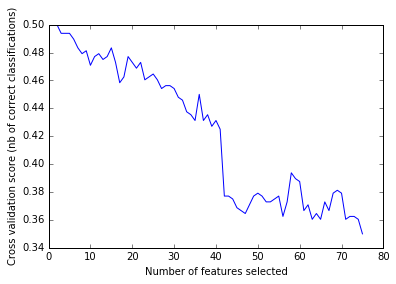

In [25]:
def plot_RFECV(X, y):
    svc = SVC(kernel="linear")
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y, 2),
                  scoring='accuracy')
    rfecv.fit(X, y)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
plot_RFECV(raw_X, raw_y)

Using the RFE's ranking system we will use only the top 'x' number of features to try to find the optimial number of features (for SVC).  'X' is roughly determined by the number of features outputted in the RFECV plot.

In [29]:
def create_RFE(X, y):
    # Create the RFE object and rank each pixel
    svc = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
    rfe.fit(X, y)
    print(rfe.ranking_)
    return rfe.ranking_
   
rankings = create_RFE(raw_X, raw_y)

[63  2 14 35 31 10 46 40 36 19  1  9  5 43 34 24 60 26 29 57 59 38 56 22  8
 44 66  6  3 21 30 67 62 33 42 49 52 47 51 41  7 53 25 13 12 20 39 69 55 64
 32 37 27  4 61 28 58 48 23 11 54 45 50 73 16 15 74 68 72 75 18 17 71 65 70]


### STEP 3
Take ranked features and reordering the features so that we can use that DF in the new models

In [27]:
def reorder_features(ranking, data):
    ranked_X = pd.DataFrame(index=range(480))
    for a in range(len(ranking)):
        for i in range(len(ranking)):
            if ranking[i] == a+1:
                ranked_X = ranked_X.join(data.ix[:,i])
    
    display(ranked_X.describe())
    return ranked_X


ranked_X = reorder_features(rankings, raw_X)

,opp_is_home,is_home,current_team_away_shots_on_target,e_f_shots_on_target,opp_avg_goals,current_team_home_shots_on_target,current_opp_away_yellow_card,current_team_away_yellow_card,opp_avg_points,avg_goals,opp_e_f_shots_on_target,current_opp_away_shots_on_target,current_opp_home_shots_on_target,avg_points,prev_opp_e_f_shots_on_target,prev_opp_e_f_shots_total,opp_opp_e_f_shots_on_target,opp_opp_e_f_shots_total,sos,current_opp_home_shots_total,current_team_home_shots_total,current_team_home_yellow_card,opp_e_f_shots_total,opp_win_percentage,current_opp_away_corner_kicks,current_team_home_possession,e_f_shots_total,e_f_possession,current_team_away_possession,current_team_away_shots_total,goals_against,current_opp_away_played,current_team_home_played,opp_goal_diff,goals_for,win_percentage,e_f_dangerous_attacks,current_team_home_dangerous_attacks,current_opp_away_shots_total,goal_diff,current_opp_home_yellow_card,current_team_away_played,opp_margin,current_team_home_corner_kicks,opp_e_f_possession,margin,current_opp_home_dangerous_attacks,opp_e_f_dangerous_attacks,current_opp_home_attacks,opp_e_f_attacks,current_opp_away_dangerous_attacks,current_opp_away_attacks,current_opp_home_corner_kicks,opp_e_f_ball_safe,current_opp_away_ball_safe,current_team_away_dangerous_attacks,current_team_home_attacks,e_f_attacks,current_team_away_attacks,opp_opp_record,e_f_ball_safe,current_team_away_ball_safe,games_played,current_opp_home_played,opp_opp_e_f_possession,current_team_away_corner_kicks,current_team_home_ball_safe,prev_opp_e_f_possession,current_opp_home_ball_safe,opp_opp_e_f_attacks,opp_opp_e_f_ball_safe,prev_opp_e_f_attacks,prev_opp_e_f_dangerous_attacks,prev_opp_e_f_ball_safe,opp_opp_e_f_dangerous_attacks
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.500000,0.500000,4.180421,4.889286,1.018750,5.581029,1.821787,1.821787,0.977083,1.018750,4.889286,4.180421,5.581029,0.977083,4.888082,9.318979,4.888082,9.318979,1.166982,10.508037,10.508037,1.490376,9.323224,0.499875,4.171249,51.822837,9.323224,49.988339,48.310725,8.140208,1.364583,6.210417,6.183333,-0.041667,1.387500,0.499875,50.899123,53.877714,8.140208,-0.041667,1.490376,6.210417,-0.427083,5.754218,49.988339,-0.427083,53.877714,50.899123,103.961271,100.651169,47.939359,97.409953,5.754218,93.548846,92.869165,47.939359,103.961271,100.651169,97.409953,0.500201,93.548846,92.869165,12.393750,6.183333,49.973943,4.171249,94.378261,49.973943,94.378261,100.678550,93.568590,100.678550,50.832550,93.568590,50.832550
std,0.500522,0.500522,1.017958,0.958921,0.506392,1.199414,0.609547,0.609547,0.557260,0.506392,0.958921,1.017958,1.199414,0.557260,0.939176,1.447742,0.939176,1.447742,0.304611,1.966769,1.966769,0.546147,1.455324,0.164815,1.326197,3.451890,1.455324,3.201906,3.606340,1.381417,1.142460,3.583116,3.579653,4.373761,1.150406,0.164815,6.953697,8.283328,1.381417,4.373761,0.546147,3.583116,0.692109,1.495950,3.201906,0.692109,8.283328,6.953697,12.758629,11.194697,7.734202,11.684308,1.495950,9.322517,9.575542,7.734202,12.758629,11.194697,11.684308,0.164743,9.322517,9.575542,6.922262,3.579653,3.152205,1.326197,10.531343,3.152205,10.531343,11.171191,9.402093,11.171191,6.915966,9.402093,6.915966
min,0.000000,0.000000,1.000000

### STEP 4
Let's try to reduce the number of features to at least 25 although optimal seems likely around ~8 features.  Note: Even though RFECV only applies to SVC still running it on the other models just to see the impact.

In [8]:
def train_ranked_models(X, y):
    
    for x in xrange(5, 25):
        print('X :: {}'.format(x))
        svc, gmm, knn, gnb = train_models(round_number, X.iloc[:, 1:x], y)
        
train_ranked_models(ranked_X, raw_y)

Plot PCA based off of optimized number in previous step

### STEP 5 Try PCA on ranked features 

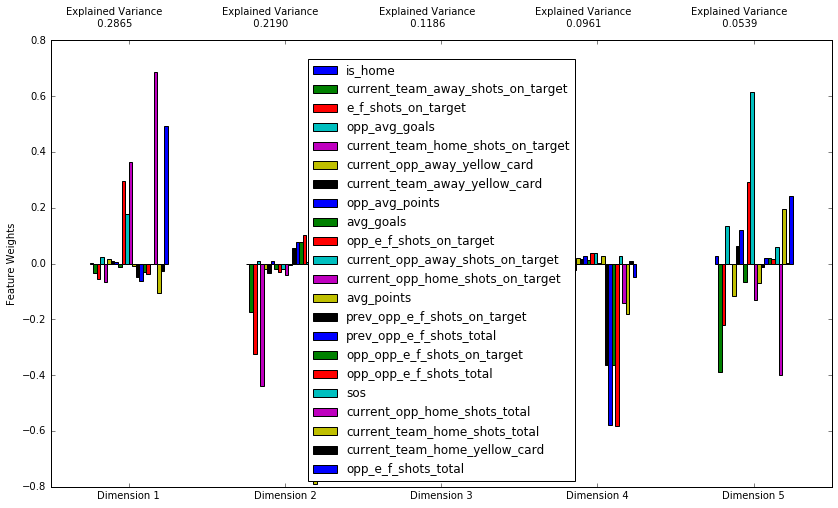

In [30]:
def plot_PCA(data):
    pca = PCA(n_components=5)
    pca.fit(data)
    # Generate PCA results plot
    pca_results = rs.pca_results(data, pca)
    
    return pca

pca = plot_PCA(ranked_X.iloc[:, 1:23])

In [32]:
def apply_PCA(pca, data):
    # TODO: Apply a PCA transformation the good data
    pca_data = pca.transform(data)
    return pca_data
    
apply_PCA(pca, ranked_X.iloc[:, 1:23])

array([[ 4.22960697, -4.66738954, -6.70687285,  0.48409107, -0.67126072],
       [ 1.30142621, -3.76438945,  3.25467707,  2.3701304 ,  2.5441066 ],
       [-2.09908628, -4.69263244, -0.55113489, -0.72161556, -1.70666032],
       ..., 
       [ 1.17459245,  3.67480524, -0.24950456,  0.35670645,  0.84947622],
       [-1.68838261,  4.15323845, -0.82089031, -0.66121512, -0.75077768],
       [ 1.28705957,  3.62280777,  0.07283782, -0.22854681, -0.50618429]])

### STEP 6 Let's try removing ties on RAW DATA (All Features and Target)

In [33]:
def remove_ties(data):
    tieless_data = data[data.points != 1]
    X, y = split_target(tieless_data)
    return X, y
    
X, y = remove_ties(raw_data)

svc, gmm, knn, gnb = train_models(round_number, X, y)

Training SVC Model


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


F1 score for training set: 0.838461538462
F1 score for test set: 0.686567164179
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.127422703177 for 2 Clusters
Silhouette Score :: 0.152621438996 for 3 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.771875
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.772058823529
F1 score for test set: 0.757575757576
Finished Gaussian NB Modeling


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


Starting with the Ranked Data, Removing Ties then 'extracting target' so we can reduce the features then run the models to find the optimal amount of features on data where there are no ties.

In [34]:
print(ranked_X.shape)
ranked_data = ranked_X.join(raw_y)

tieless_X, tieless_y = remove_ties(ranked_data)

#'16' here is just the number where the optimal number of features was found above.  
svc, gmm, knn, gnb = train_models(round_number, tieless_X.iloc[:, 1:16], tieless_y)

(480, 75)
Training SVC Model


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


F1 score for training set: 0.7421875
F1 score for test set: 0.78125
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.168822020878 for 2 Clusters
Silhouette Score :: 0.0778223781622 for 3 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.825
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.721568627451
F1 score for test set: 0.793650793651
Finished Gaussian NB Modeling


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


## Part 2
Run all the above steps but using standard features and the Home/Away Features - Create Home/Away Data.  Home/Away Data is my attempt to try to split out the difference in how a current team's play varies from away and home.  For instance, instead of just averaging a teams goal scored from all games, average a teams goal scored on home games and away games.  If in that match they are the home team, only use the home average.  If they are away, use the away average.

In [13]:
# ha = home-away
standard_cols = ['games_played', 'is_home', 'avg_points', 'goals_for', 'goals_against', 'avg_goals', 'margin', 'goal_diff',
                'win_percentage', 'sos', 'opp_avg_points', 'opp_avg_goals', 'opp_margin', 'opp_goal_diff', 'opp_win_percentage',
                'opp_opp_record', 'points']
# 17 each
home_cols = ['current_team_home_possession', 'current_team_home_attacks', 'current_team_home_dangerous_attacks', 'current_team_home_yellow_card',
            'current_team_home_corner_kicks', 'current_team_home_shots_on_target', 'current_team_home_shots_total', 'current_team_home_ball_safe',
            'current_team_home_played', 'current_opp_away_attacks', 'current_opp_away_dangerous_attacks', 'current_opp_away_yellow_card',
            'current_opp_away_corner_kicks', 'current_opp_away_shots_on_target', 'current_opp_away_shots_total', 'current_opp_away_ball_safe',
            'current_opp_away_played']
away_cols = ['current_team_away_possession', 'current_team_away_attacks', 'current_team_away_dangerous_attacks', 'current_team_away_yellow_card', 
            'current_team_away_corner_kicks', 'current_team_away_shots_on_target', 'current_team_away_shots_total', 'current_team_away_ball_safe', 
            'current_team_away_played', 'current_opp_home_attacks', 'current_opp_home_dangerous_attacks', 'current_opp_home_yellow_card', 'current_opp_home_corner_kicks', 
             'current_opp_home_shots_on_target', 'current_opp_home_shots_total', 'current_opp_home_ball_safe', 'current_opp_home_played']

def rename_column(label):
    if label.count('_home_') > 0:
        new_name = label.replace('_home_', '_')
    elif label.count('_away_') > 0:
        new_name = label.replace('_away_', '_')
    return new_name

# Creates new column list for merged columns
merged_cols = []

for cols in home_cols:
    merged_cols.append(rename_column(cols))
    
# Creates a Home and Away Table with Standard and Home/Away Columns.  Will evenutally merge together
ha_data = model_libs._clone_and_drop(raw_data, ignore_cols)
home_data = ha_data.loc[ha_data.loc[:, 'is_home'] == 1, standard_cols + home_cols]
away_data = ha_data.loc[ha_data.loc[:, 'is_home'] == 0, standard_cols + away_cols]

# Appends the Home Table with the Away Table
ha_data = home_data.append(away_data)

def pick_column(home, away):
    if np.isnan(home):
        return away
    elif np.isnan(away):
        return home

# Combine Home/Away Columns into one for Current Team and Opponent.  Cuts down on Features
# Adds from whatever column that doesn't have Nan
for c in range(len(merged_cols)):
    ha_data[merged_cols[c]] = ha_data.apply(lambda row: pick_column(row[home_cols[c]], row[away_cols[c]]), axis=1 )

ha_data = ha_data.drop(home_cols + away_cols, axis=1)

print(ha_data.shape)
display(ha_data.describe())

(480, 34)


,avg_goals,avg_points,games_played,goal_diff,goals_against,goals_for,is_home,margin,opp_avg_goals,opp_avg_points,opp_goal_diff,opp_margin,opp_opp_record,opp_win_percentage,points,sos,win_percentage,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_yellow_card,current_team_corner_kicks,current_team_shots_on_target,current_team_shots_total,current_team_ball_safe,current_team_played,current_opp_attacks,current_opp_dangerous_attacks,current_opp_yellow_card,current_opp_corner_kicks,current_opp_shots_on_target,current_opp_shots_total,current_opp_ball_safe,current_opp_played
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,1.018750,0.977083,12.393750,-0.041667,1.364583,1.387500,0.500000,-0.427083,1.018750,0.977083,-0.041667,-0.427083,0.500201,0.499875,1.333333,1.166982,0.499875,50.004392,100.841481,50.969118,1.659965,4.988794,4.889909,9.345730,93.778691,5.995833,100.841481,50.969118,1.659965,4.988794,4.889909,9.345730,93.778691,5.995833
std,0.506392,0.557260,6.922262,4.373761,1.142460,1.150406,0.500522,0.692109,0.506392,0.557260,4.373761,0.692109,0.164743,0.164815,1.248520,0.304611,0.164815,3.825790,12.731148,8.455986,0.597197,1.656228,1.292097,2.071212,10.554401,3.545703,12.731148,8.455986,0.597197,1.656228,1.292097,2.071212,10.554401,3.545703
min,0.000000,0.000000,1.000000,-20.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,-20.000000,-3.000000,0.000000,0.000000,0.000000,0.185185,0.000000,34.000000,65.000000,28.500000,0.000000,0.000000,0.000000,3.000000,45.000000,0.000000,65.000000,28.500000,0.000000,0.000000,0.000000,3.000000,45.000000,0.000000
25%,1.000000,1.000000,6.000000,-3.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,-3.000000,-1.000000,0.407407,0.408670,0.000000,0.997418,0.408670,47.500000,93.000000,45.650000,1.296429,3.833333,4.000000,8.000000,88.750000,3.000000,93.000000,45.650000,1.296429,3.833333,4.000000,8.000000,88.750000,3.000000
50%,1.000000,1.000000,12.500000,0.000000,1.000000,1.000000,0.500000,0.000000,1.000000,1.000000,0.000000,0.000000,0.500000,0.500000,1.000000,1.152499,0.500000,50.000000,98.850000,50.428571,1.600000,5.000000,4.857143,9.045455,93.707143,6.000000,98.850000,50.428571,1.600000,5.000000,4.857143,9.045455,93.707143,6.000000
75%,1.000000,1.000000,18.000000,2.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.590909,0.588612,3.000000,1.336093,0.588612,52.200000,109.343750,55.500000,2.000000,6.000000,5.666667,10.666667,99.666667,9.000000,109.343750,55.500000,2.000000,6.000000,5.666667,10.666667,99.666667,9.000000
max,4.000000,3.000000,26.000000,13.000000,7.000000,7.000000,1.000000,3.000000,4.000000,3.000000,13.000000,3.000000,1.000000,1.000000,3.000000,2.166667,1.000000,66.000000,143.000000,78.400000,5.000000,12.000000,9.000000,16.000000,128.000000,14.000000,143.000000,78.400000,5.000000,12.000000,9.000000,16.000000,128.000000,14.000000


 :: Split Home/Away Data :: 
Training SVC Model
F1 score for training set: 0.577654120941
F1 score for test set: 0.471782057689
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.145719024275 for 2 Clusters
Silhouette Score :: 0.121960411599 for 3 Clusters
Silhouette Score :: 0.127627218888 for 4 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.66875
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.518477550907
F1 score for test set: 0.482790963217
Finished Gaussian NB Modeling

 :: Train Tuned Models on Home/Away Data - This will take awhile... :: 
Training and Tuning SVC Model
[ 0.33160622  0.39267016]
Accuracy: 0.36 (+/- 0.06)
Finished SVC Modeling
-----------------------------------
Training and Tuning GMM Model
W/ Covariance Type :: spherical
# of Components :: 2
Silhouette Score :: 0.18401887

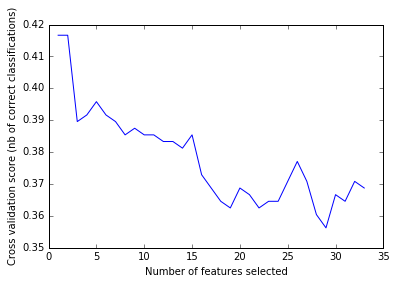


 :: Ranking the features in terms of importance :: 
[11 26 21 18 14 17  1  5  3  2 19  8 13 16 15 23 22 32 33  9 10 27 12 30 20
 29 28  4  6 25  7 31 24]

 :: Reordering the Home/Away Data in terms of ranked features :: 


,is_home,opp_avg_points,opp_avg_goals,current_opp_yellow_card,margin,current_opp_corner_kicks,current_opp_shots_total,opp_margin,current_team_yellow_card,current_team_corner_kicks,avg_goals,current_team_shots_total,opp_opp_record,goals_against,sos,opp_win_percentage,goals_for,goal_diff,opp_goal_diff,current_team_played,games_played,current_team_possession,win_percentage,current_opp_played,current_opp_shots_on_target,avg_points,current_team_shots_on_target,current_opp_dangerous_attacks,current_opp_attacks,current_team_ball_safe,current_opp_ball_safe,current_team_attacks,current_team_dangerous_attacks
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.500000,0.977083,1.018750,1.659965,-0.427083,4.988794,9.345730,-0.427083,1.659965,4.988794,1.018750,9.345730,0.500201,1.364583,1.166982,0.499875,1.387500,-0.041667,-0.041667,5.995833,12.393750,50.004392,0.499875,5.995833,4.889909,0.977083,4.889909,50.969118,100.841481,93.778691,93.778691,100.841481,50.969118
std,0.500522,0.557260,0.506392,0.597197,0.692109,1.656228,2.071212,0.692109,0.597197,1.656228,0.506392,2.071212,0.164743,1.142460,0.304611,0.164815,1.150406,4.373761,4.373761,3.545703,6.922262,3.825790,0.164815,3.545703,1.292097,0.557260,1.292097,8.455986,12.731148,10.554401,10.554401,12.731148,8.455986
min,0.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,3.000000,-3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.185185,0.000000,0.000000,-20.000000,-20.000000,0.000000,1.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.500000,65.000000,45.000000,45.000000,65.000000,28.500000
25%,0.000000,1.000000,1.000000,1.296429,-1.000000,3.833333,8.000000,-1.000000,1.296429,3.833333,1.000000,8.000000,0.407407,0.000000,0.997418,0.408670,0.000000,-3.000000,-3.000000,3.000000,6.000000,47.500000,0.408670,3.000000,4.000000,1.000000,4.000000,45.650000,93.000000,88.750000,88.750000,93.000000,45.650000
50%,0.500000,1.000000,1.000000,1.600000,0.000000,5.000000,9.045455,0.000000,1.600000,5.000000,1.000000,9.045455,0.500000,1.000000,1.152499,0.500000,1.000000,0.000000,0.000000,6.000000,12.500000,50.000000,0.500000,6.000000,4.857143,1.000000,4.857143,50.428571,98.850000,93.707143,93.707143,98.850000,50.428571
75%,1.000000,1.000000,1.000000,2.000000,0.000000,6.000000,10.666667,0.000000,2.000000,6.000000,1.000000,10.666667,0.590909,2.000000,1.336093,0.588612,2.000000,2.000000,2.000000,9.000000,18.000000,52.200000,0.588612,9.000000,5.666667,1.000000,5.666667,55.500000,109.343750,99.666667,99.666667,109.343750,55.500000
max,1.000000,3.000000,4.000000,5.000000,3.000000,12.000000,16.000000,3.000000,5.000000,12.000000,4.000000,16.000000,1.000000,7.000000,2.166667,1.000000,7.000000,13.000000,13.000000,14.000000,26.000000,66.000000,1.000000,14.000000,9.000000,3.000000,9.000000,78.400000,143.000000,128.000000,128.000000,143.000000,78.400000



 :: Training new ranked data and eliminating some features :: 
X :: 5
Training SVC Model
F1 score for training set: 0.383983913754
F1 score for test set: 0.318742108785
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.268420712053 for 2 Clusters
Silhouette Score :: 0.280813755523 for 3 Clusters
Silhouette Score :: 0.293561477406 for 4 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.5625
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.348743566455
F1 score for test set: 0.311535760528
Finished Gaussian NB Modeling
X :: 6
Training SVC Model
F1 score for training set: 0.351138278608
F1 score for test set: 0.3
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.128738448298 for 2 Clusters
Silhouette Score :: 0.186969963109 for 3 Clusters
Silhouette

//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


F1 score for training set: 0.838461538462
F1 score for test set: 0.686567164179
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.127422703177 for 2 Clusters
Silhouette Score :: 0.152621438996 for 3 Clusters
Silhouette Score :: 0.140551602555 for 4 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.771875
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.772058823529
F1 score for test set: 0.757575757576
Finished Gaussian NB Modeling

 :: Joined the target value back to Ranked X :: 

 :: Removing Ties from the Ranked Features Data :: 

 :: Training and then comparing Ranked Features against the Raw Data with Ties removed :: 
Training SVC Model


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning

F1 score for training set: 0.766798418972
F1 score for test set: 0.603174603175
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.0971918660708 for 2 Clusters
Silhouette Score :: 0.044089479328 for 3 Clusters
Silhouette Score :: 0.00364802870753 for 4 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.828125
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.674329501916
F1 score for test set: 0.666666666667
Finished Gaussian NB Modeling

 :: Finished with Home/Away Features :: 


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


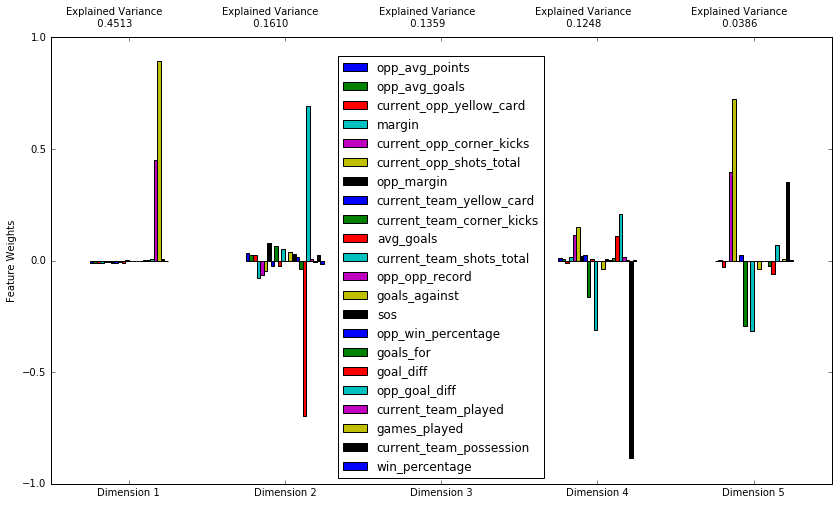

In [17]:
ha_X, ha_y = split_target(ha_data)
print(' :: Split Home/Away Data :: ')
svc, gmm, knn, gnb = train_models(round_number, ha_X, ha_y)
print('\n :: Train Tuned Models on Home/Away Data - This will take awhile... :: ')
train_tuned_models(round_number, ha_X, ha_y)
print('\n :: Plotting RFECV to understand the optimal amount of features :: ')
plot_RFECV(ha_X, ha_y)
print('\n :: Ranking the features in terms of importance :: ')
ha_rankings = create_RFE(ha_X, ha_y)
print('\n :: Reordering the Home/Away Data in terms of ranked features :: ')
ha_ranked_X = reorder_features(ha_rankings, ha_X)
print('\n :: Training new ranked data and eliminating some features :: ')
train_ranked_models(ha_ranked_X, ha_y)
print('\n :: Plotting PCA to cut down on dimensions :: ')
ha_pca = plot_PCA(ha_ranked_X.iloc[:, 1:23])
print('\n :: Apply the PCA so we can use fewer dimensions :: ')
pca_data = apply_PCA(ha_pca, ha_ranked_X.iloc[:, 1:23])
print('\n :: Train models based on PCA Data :: ')
svc, gmm, knn, gnb = train_models(round_number, pca_data, raw_y)
print('\n :: Removing Ties on Raw Data :: ')
X, y = remove_ties(raw_data)
print('\n :: Run Training on Removing Ties from the Raw Data :: ')
svc, gmm, knn, gnb = train_models(round_number, X, y)
print('\n :: Joined the target value back to Ranked X :: ')
ha_ranked_data = ha_ranked_X.join(ha_y)
print('\n :: Removing Ties from the Ranked Features Data :: ')
ha_tieless_X, ha_tieless_y = remove_ties(ha_ranked_data)
print('\n :: Training and then comparing Ranked Features against the Raw Data with Ties removed :: ')
svc, gmm, knn, gnb = train_models(round_number, ha_tieless_X.iloc[:, 1:16], ha_tieless_y)
print('\n :: Finished with Home/Away Features :: ')

## Part 3
Run all the above steps but using the standard features and the extended features.  Extended Features is an attempt to use not just the current team and the team they are playing in that match up.  But also to use compare the current teams previous opponents and the current teams opponents opponents.  


 :: Split Extended Features Data :: 
Training SVC Model
F1 score for training set: 0.599626140087
F1 score for test set: 0.400525924216
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.212020941494 for 2 Clusters
Silhouette Score :: 0.0848784293376 for 3 Clusters
Silhouette Score :: 0.0908030877349 for 4 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.616666666667
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.516343118922
F1 score for test set: 0.379661016949
Finished Gaussian NB Modeling

 :: Train Tuned Models on Extended Features Data - This will take awhile... :: 
Training and Tuning SVC Model
[ 0.40932642  0.38743455]
Accuracy: 0.40 (+/- 0.02)
Finished SVC Modeling
-----------------------------------
Training and Tuning GMM Model
W/ Covariance Type :: spherical
# of Components :: 2
Silh

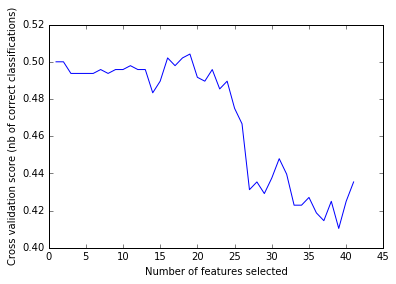


 :: Ranking the features in terms of importance :: 
[40  2 23 28 20  7  5 22  3  4  1 17 21 16 18 19 12 38 11  8 29 25 39 33 13
 10 31 24 35 32 14 15 34 27 41 30  9  6 36 26 37]

 :: Reordering the Extended Features Data in terms of ranked features :: 


,margin,sos,win_percentage,opp_e_f_possession,goal_diff,opp_e_f_attacks,prev_opp_e_f_shots_total,opp_avg_points,e_f_shots_on_target,e_f_ball_safe,games_played,e_f_attacks,opp_avg_goals,goals_against,opp_goal_diff,opp_margin,avg_goals,goals_for,opp_is_home,opp_e_f_shots_total,avg_points,opp_opp_record,opp_win_percentage,prev_opp_e_f_ball_safe,prev_opp_e_f_dangerous_attacks,is_home,e_f_possession,opp_e_f_ball_safe,opp_e_f_shots_on_target,opp_e_f_dangerous_attacks,prev_opp_e_f_shots_on_target,e_f_dangerous_attacks,e_f_shots_total
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,-0.427083,1.166982,0.499875,49.988339,-0.041667,100.651169,9.318979,0.977083,4.889286,93.548846,12.393750,100.651169,1.018750,1.364583,-0.041667,-0.427083,1.018750,1.387500,0.500000,9.323224,0.977083,0.500201,0.499875,93.568590,50.832550,0.500000,49.988339,93.548846,4.889286,50.899123,4.888082,50.899123,9.323224
std,0.692109,0.304611,0.164815,3.201906,4.373761,11.194697,1.447742,0.557260,0.958921,9.322517,6.922262,11.194697,0.506392,1.142460,4.373761,0.692109,0.506392,1.150406,0.500522,1.455324,0.557260,0.164743,0.164815,9.402093,6.915966,0.500522,3.201906,9.322517,0.958921,6.953697,0.939176,6.953697,1.455324
min,-3.000000,0.185185,0.000000,34.000000,-20.000000,65.000000,3.000000,0.000000,0.000000,45.000000,1.000000,65.000000,0.000000,0.000000,-20.000000,-3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,45.000000,31.333333,0.000000,34.000000,45.000000,0.000000,31.333333,0.000000,31.333333,3.000000
25%,-1.000000,0.997418,0.408670,48.369485,-3.000000,93.400000,8.600000,1.000000,4.311842,89.272727,6.000000,93.400000,1.000000,0.000000,-3.000000,-1.000000,1.000000,0.000000,0.000000,8.625000,1.000000,0.407407,0.408670,89.187500,46.937500,0.000000,48.369485,89.272727,4.311842,46.833333,4.328947,46.833333,8.625000
50%,0.000000,1.152499,0.500000,49.544444,0.000000,98.820856,9.428571,1.000000,4.916667,93.828571,12.500000,98.820856,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.500000,9.428571,1.000000,0.500000,0.500000,93.971739,50.122222,0.500000,49.544444,93.828571,4.916667,50.192029,4.894737,50.192029,9.428571
75%,0.000000,1.336093,0.588612,51.583333,2.000000,108.454545,10.011364,1.000000,5.439236,99.166667,18.000000,108.454545,1.000000,2.000000,2.000000,0.000000,1.000000,2.000000,1.000000,10.066667,1.000000,0.590909,0.588612,99.172619,54.400000,1.000000,51.583333,99.166667,5.439236,54.270833,5.428571,54.270833,10.066667
max,3.000000,2.166667,1.000000,66.000000,13.000000,143.000000,14.000000,3.000000,9.000000,128.000000,26.000000,143.000000,4.000000,7.000000,13.000000,3.000000,4.000000,7.000000,1.000000,14.000000,3.000000,1.000000,1.000000,128.000000,77.000000,1.000000,66.000000,128.000000,9.000000,77.000000,9.000000,77.000000,14.000000



 :: Training new ranked data and eliminating some features :: 
X :: 5
Training SVC Model
F1 score for training set: 0.700303256476
F1 score for test set: 0.375661375661
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.15196151839 for 2 Clusters
Silhouette Score :: 0.194019983745 for 3 Clusters
Silhouette Score :: 0.159869002859 for 4 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.65
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.392885133415
F1 score for test set: 0.267465558001
Finished Gaussian NB Modeling
X :: 6
Training SVC Model
F1 score for training set: 0.372184767942
F1 score for test set: 0.3193999158
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.241970051821 for 2 Clusters
Silhouette Score :: 0.153544673921 for 3 Clusters
Silh

//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


F1 score for training set: 0.838461538462
F1 score for test set: 0.686567164179
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.127422703177 for 2 Clusters
Silhouette Score :: 0.151986009723 for 3 Clusters
Silhouette Score :: 0.139299873931 for 4 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.771875
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.772058823529
F1 score for test set: 0.757575757576
Finished Gaussian NB Modeling

 :: Joined the target value back to Ranked X :: 

 :: Removing Ties from the Ranked Features Data :: 

 :: Training and then comparing Ranked Features against the Raw Data with Ties removed :: 
Training SVC Model


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning

F1 score for training set: 0.610687022901
F1 score for test set: 0.555555555556
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.167806313483 for 2 Clusters
Silhouette Score :: 0.0557115173252 for 3 Clusters
Silhouette Score :: 0.0857245173958 for 4 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.75625
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.615384615385
F1 score for test set: 0.589743589744
Finished Gaussian NB Modeling

 :: Finished with Extended Features :: 


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


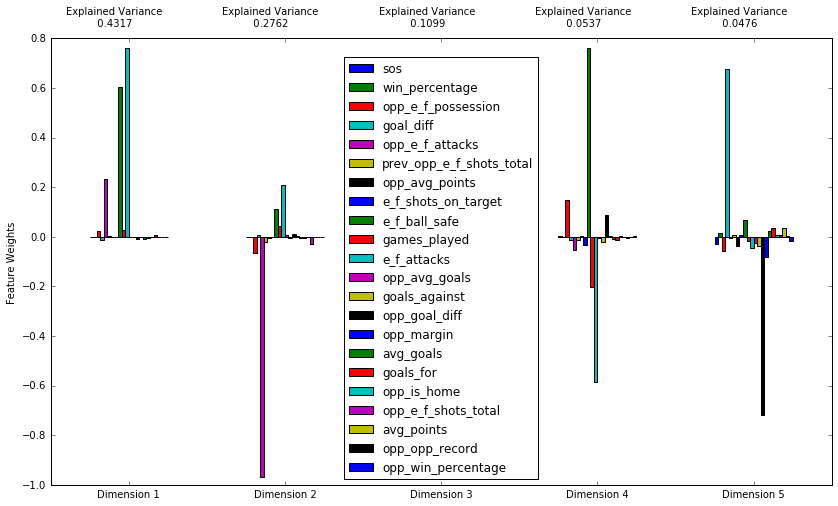

In [19]:
# ef = extended features
ef_data = model_libs._clone_and_drop(raw_data, ignore_cols)
ef_data = ef_data.drop(home_cols + away_cols, axis=1)

ef_X, ef_y = split_target(ef_data)
print('\n :: Split Extended Features Data :: ')
svc, gmm, knn, gnb = train_models(round_number, ef_X, ef_y)
print('\n :: Train Tuned Models on Extended Features Data - This will take awhile... :: ')
train_tuned_models(round_number, ef_X, ef_y)
print('\n :: Plotting RFECV to understand the optimal amount of features :: ')
plot_RFECV(ef_X, ef_y)
print('\n :: Ranking the features in terms of importance :: ')
ef_rankings = create_RFE(ef_X, ef_y)
print('\n :: Reordering the Extended Features Data in terms of ranked features :: ')
ef_ranked_X = reorder_features(ha_rankings, ef_X)
print('\n :: Training new ranked data and eliminating some features :: ')
train_ranked_models(ef_ranked_X, ef_y)
print('\n :: Plotting PCA to cut down on dimensions :: ')
ef_pca = plot_PCA(ef_ranked_X.iloc[:, 1:23])
print('\n :: Apply the PCA so we can use fewer dimensions :: ')
pca_data = apply_PCA(ef_pca, ef_ranked_X.iloc[:, 1:23])
print('\n :: Train models based on PCA Data :: ')
svc, gmm, knn, gnb = train_models(round_number, pca_data, raw_y)
print('\n :: Removing Ties on Raw Data :: ')
X, y = remove_ties(raw_data)
print('\n :: Run Training on Removing Ties from the Raw Data :: ')
svc, gmm, knn, gnb = train_models(round_number, X, y)
print('\n :: Joined the target value back to Ranked X :: ')
ef_ranked_data = ef_ranked_X.join(ef_y)
print('\n :: Removing Ties from the Ranked Features Data :: ')
ef_tieless_X, ef_tieless_y = remove_ties(ef_ranked_data)
print('\n :: Training and then comparing Ranked Features against the Raw Data with Ties removed :: ')
svc, gmm, knn, gnb = train_models(round_number, ef_tieless_X.iloc[:, 1:16], ef_tieless_y)
print('\n :: Finished with Extended Features :: ')

Using desired model to predict upcoming matches :: Right now these are the best performing models with the best performing feature.  Seems just removing ties on the 'raw data' has the best impact 

In [14]:
print('\n :: Removing Ties on Raw Data :: ')
X, y = remove_ties(raw_data)
print('\n :: Run Training on Removing Ties from the Raw Data :: ')
svc, gmm, knn, gnb = train_models(round_number, X, y)


 :: Removing Ties on Raw Data :: 

 :: Run Training on Removing Ties from the Raw Data :: 
Training SVC Model


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


F1 score for training set: 0.838461538462
F1 score for test set: 0.686567164179
Finished SVC Modeling
-----------------------------------
Training GMM Modeling
Silhouette Score :: 0.138327858183 for 2 Clusters
Silhouette Score :: 0.152621438996 for 3 Clusters
Finished GMM Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.771875
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.772058823529
F1 score for test set: 0.757575757576
Finished Gaussian NB Modeling


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


### Part 4

Use these models trained on the optimal data to predict upcoming matches

Find upcoming matches...

In [4]:
# upcoming_matches, match_details = predict_matches.get_upcoming_matches()
# upcoming_matches.to_csv('upcoming_matches.csv')
# match_details.to_csv('match_details.csv')
# print("Upcoming Data Saved to CSV")

upcoming_matches = pd.read_csv('upcoming_matches.csv')
upcoming_matches = upcoming_matches.drop(upcoming_matches.columns[[0]], axis=1)

match_details = pd.read_csv('match_details.csv')
match_details = match_details.drop(match_details.columns[[0]], axis=1)

display(upcoming_matches)

,match_id,scheduled,home_id,away_id,home_team,away_team
0,486,2016-09-01 23:00:00,24,33,New York City FC,DC United
1,487,2016-09-03 23:00:00,28,31,Vancouver Whitecaps FC,NY Red Bulls
2,488,2016-09-03 23:30:00,36,22,New England Revolution,Colorado Rapids
3,489,2016-09-04 00:30:00,40,25,Chicago Fire,Philadelphia Union
4,490,2016-09-04 01:00:00,21,30,FC Dallas,Portland Timbers
5,491,2016-09-04 02:30:00,26,39,LA Galaxy,Columbus Crew


Make predictions on upcoming data

In [19]:
for i in models:
    if i == 'svc':
        svc_preds, upcoming_data = predict_matches.predictions(upcoming_matches, match_details, svc)
        print(svc_preds)
    elif i == 'gmm':
        gmm_preds, upcoming_data = predict_matches.predictions(upcoming_matches, match_details, gmm)
        print(gmm_preds)
    elif i == 'knn':
        knn_preds, upcoming_data = predict_matches.predictions(upcoming_matches, match_details, knn)
        print(knn_preds)
    elif i == 'gnb':
        gnb_preds, upcoming_data = predict_matches.predictions(upcoming_matches, match_details, gnb)
        print(gnb_preds)

[ 3.  0.  3.  0.  3.  3.  0.  0.  0.  0.  0.  3.]
[0 1 0 0 0 2 0 1 0 2 0 0]
[ 3.  0.  3.  3.  3.  3.  0.  0.  0.  3.  0.  0.]
[ 3.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  3.]


Output those predictions to a CSV so easier to visualize

In [20]:
columns = ['team_name', 'opp_name', 'scheduled']
# Remove all columns except the ones above
upcoming_matches = upcoming_data[columns]

# Add predictions to the end of that DF
results = pd.DataFrame({'SVC': svc_preds, 'GMM': gmm_preds, 'KNN': knn_preds, 'GNB': gnb_preds})
upcoming_matches = upcoming_matches.join(results)
reordered_matches = pd.DataFrame([])

for rows in upcoming_matches.iterrows():
    for i in upcoming_matches['team_name']:
        if rows[1]['opp_name'] == i:
            reordered_matches = reordered_matches.append(rows[1])
            reordered_matches = reordered_matches.append(upcoming_matches[upcoming_matches['team_name'].isin([i])])

reordered_matches = reordered_matches.drop_duplicates() 
columns = ['scheduled', 'team_name', 'opp_name', 'SVC', 'KNN', 'GMM', 'GNB']
reordered_matches = reordered_matches[columns]
# upcoming_matches = upcoming_matches[(upcoming_matches['scheduled'] < '2016-08-26')]
reordered_matches.to_csv('predictions_' + str(round_number) + '.csv')
print('Prediction CSV saved')

Prediction CSV saved


### RESULTS

Excluding GMM...

FC Dallas vs Portland Timbers :: 3-1 (Unanimously Dallas)
New England Revolution vs Colorado Rapids :: 2-0 (Mixed, 1 model picked NER to win)
New York City FC vs DC United :: 3-2 (Unanimously NYCFC)
Chicago Fire vs Philadelphia Union :: 3-0 (2 models picked Chi and 1 picked Phi)
Vancouver Whitecaps vs New York Red Bulls :: 0-1
LA Galaxy vs Columbus Crew :: 2-1

My Questions:
- For GMM, how can we tell what classification it's predicting.  If you notice in the predictions CSV it says 0, 1, 2.  How do I know which one of those are win, draw, or a loss (3, 1, 0)?